## Projet 7 : Réalisez une analyse de sentiments grâce au Deep Learning

## Contexte

Vous êtesingénieur IA chez "Marketing Intelligence Consulting", une entreprise de conseil spécialisée sur les problématiques de marketing digital.

"Air Paradis" a missionné votre cabinet pour créer un produit IA permettant d’anticiper les bad buzz sur les réseaux sociaux en permettant de prédire le sentiment associé à un tweet.

Marc, votre manager, vous demande de tester plusieurs approches :
- approche “Modèle sur mesure simple”, pour développer rapidement un modèle classique (ex : régression logistique) permettant de prédire le sentiment associé à un tweet.
- approche “Modèle sur mesure avancé” pour développer un modèle basé sur des réseaux de neurones profonds pour prédire le sentiment associé à un tweet. => C’est ce modèle qui sera déployé et montré à Air Paradis.

Une démarche MLOPS devra être mis en oeuvre.

Le déploiement selon un pipeline continu du modèle via API intègrera également des tests unitaires automatisés.

Un suivi de performance du modèle en production sera également mis en place.

## Librairies utilisées avec le langage Python :

In [ ]:
# pip install tweet-preprocessor

In [ ]:
# Importation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import json
import preprocessor as p
import nltk
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from collections import Counter
import os
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\celine.lesur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\celine.lesur\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\celine.lesur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\celine.lesur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\celine.lesur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
if torch.cuda.is_available():
    print(f"GPU détecté : {torch.cuda.get_device_name(0)}")
else:
    print("Aucun GPU détecté")

GPU détecté : Quadro P600


In [ ]:
  # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  # model = MyModel().to(device)
  # data = data.to(device)


## Données textuelles brutes:

Le csv initial n'a pas d'en-tête. Ajoutons-en un :

In [ ]:
header = ['target','id','date','flag','user','text']

with open('D:/tutorial-env/OCR/Projet7/training.1600000.processed.noemoticon.csv', 'r', encoding='latin') as fileread:
  data = fileread.readlines()

with open('D:/tutorial-env/OCR/Projet7/csv_p7_entete.csv', 'w', encoding='latin') as f:
  writer = csv.writer(f)
  writer.writerow(header)
  f.writelines(data)

In [ ]:
# Importation de data :
data = pd.read_csv('D:/tutorial-env/OCR/Projet7/csv_p7_entete.csv',encoding='latin',delimiter=",")
data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
data.shape

(1600000, 6)

Notre base de données comprend 1600000 tweets postés définis par 6 variables.

In [ ]:
data = data.astype(str)
data.describe(include = 'all')

,target,id,date,flag,user,text
count,1600000,1600000,1600000,1600000,1600000,1600000
unique,2,1598315,774363,1,659775,1581466
top,0,2190457769,Mon Jun 15 12:53:14 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,800000,2,20,1600000,549,210


La variable "flag" n'a qu'une seule valeur et n'est donc pas pertinente.

De même, les variables "id", "date" et "user" n'ont pas d'intérêt pour notre projet.

## Dataframe spécifique :

Nous ne garderons que les variables intéressantes pour notre cas d'usage, c'est à dire la classification des tweets :     
- target
- text

In [ ]:
# Dataframe des variables sélectionnées :
data_txt = data [['target','text']]

data_txt.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Fonction permettant de visualiser le pourcentage de valeurs manquantes par variables

def show_miss_val(data : pd.DataFrame) -> pd.DataFrame:

    '''Prend dataframe `data` en entrée et calcule le pourcentage de valeurs manquantes pour chaque colonne
    Args:
        data (pd.DataFrame): Dataframe sur lequel les pourcentages de valeurs manquantes seront calculées
    Sortie:
        pd.DataFrame: Dataframe avec le pourcentage de valeurs manquantes pour chaque colonne

    '''
    variables = []
    miss_val = []

    for item in data.columns:
        variables.append(item)
        #Calcul du pourcentage de valeurs manquantes
        miss_val.append(data[item].isna().mean())

    # Création d'un dataframe avec le résultat
    output = pd.DataFrame({
        'variable': variables,
        'miss_val': miss_val
    })
    # Affichage d'un message récapitulant le nombre de variables et le nombre d'entre elles qui a des valeurs manquantes
    num_total_vars = data.shape[1]
    num_vars_missing = output[output['miss_val'] != 0].shape[0]
    print (f"Notre dataframe a  {num_total_vars} variables.\n"
           f"Il y a  {num_vars_missing} variables contenant des valeurs manquantes.")

    # Retourne les colonnes qui ont des valeurs manquantes avec le pourcentage de valeurs manquantes de chacune d'entre elles
    return output[output['miss_val'] != 0].sort_values('miss_val')

In [ ]:
#  Appel de la fonction affichant le pourcentage de valeur manquantes par variable
data_txt_vm = show_miss_val(data_txt)
data_txt_vm.head(5)

Notre dataframe a  2 variables.
Il y a  0 variables contenant des valeurs manquantes.


,variable,miss_val


Il n'y a aucune valeur manquante dans notre dataframe.

In [ ]:
data_txt.duplicated().sum()

16309

Il y a 16309 doublons dans notre dataframe que nous allons supprimer.

In [ ]:
data_txt = data_txt.drop_duplicates()
data_txt.shape

(1583691, 2)

Notre dataframe de travail finalisé comprend 1583691 tweets et leur classification "target".

## Analyse exploratoire univariée :

### Cible : target

In [ ]:
def describe_data_qual(data: pd.DataFrame,
                    col: str) :
    '''Génère des visualisation graphiques pour une colonne catégorielle d'un dataframe
    Args:
        data (pd.DataFrame): Dataframe contenant les données à analyser
        col (str): Nom de la colonne que l'on veut analyser
    Sortie:
        Histogramme des fréquences des catégories de la colonne
        Diagramme circulaire des fréquences des catégories de la colonne
    '''
    # Filtrage des données nulles
    mask = data[col].notnull()
    df = data[mask]

    # Données à visualiser
    x=df[col]

    # Fréquences et étiquettes triées par index
    labels = list(x.value_counts().sort_values(ascending = False).index.astype(str))
    frequencies = x.value_counts().sort_values(ascending = False)

    # Propriétés graphiques de la figure principale
    fig = plt.figure(figsize=(10,6))
    plt.suptitle(f"Distribution de : {col}", fontsize=25)

    # Propriétés graphiques du premier graphique (histogramme)
    ax1 = plt.subplot(121)
    ax1.set_ylabel(col, fontsize=20)
    ax1.set_xlabel("Frequences", fontsize=20)

    # Propriétés graphiques du deuxième graphique (diagramme circulaire)
    ax2 = plt.subplot(122)
    ax2.set_xlabel("Frequences en %", fontsize=20)

    # Tracer les graphiques
    ax1.barh(labels, frequencies)
    ax2.pie(frequencies,autopct='%1.2f%%',shadow=True )

    # Ajouter une légende
    ax2.legend(labels, loc = 'upper right', bbox_to_anchor = (1.5, 1))

    # Afficher les graphiques
    plt.show()

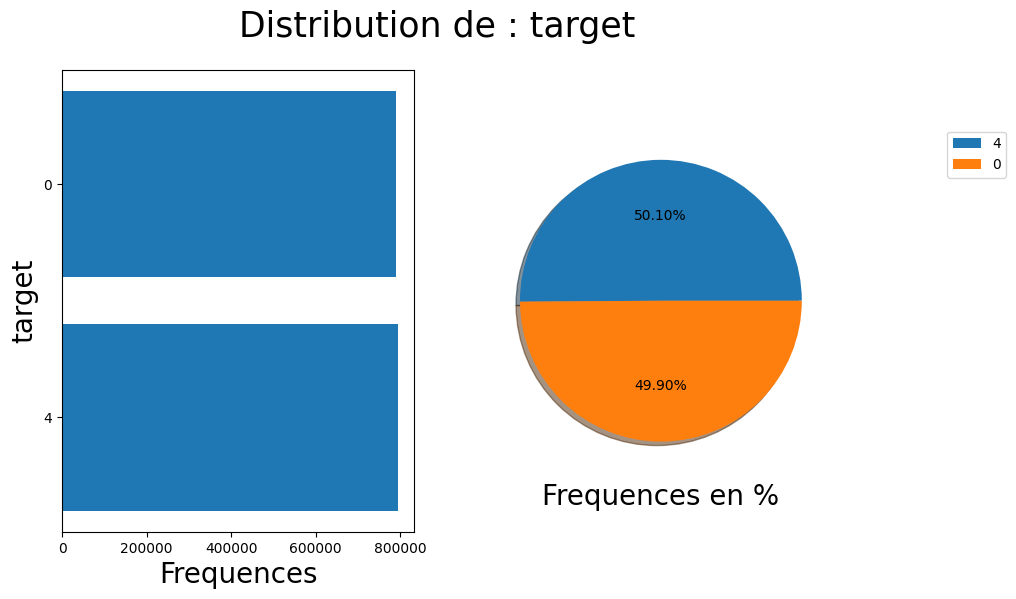

In [ ]:
describe_data_qual(data_txt, 'target')

La distribution de target est quasiment équivalente, nous n'avons donc pas une classe sous ou sur représentée.

Les deux valeurs possibles de target sont 0 ou 4 qui correspond respectivement à un sentiment négatif ou positif.

Remplaçons les valeurs 4 par 1 pour avoir une variable binaire à prédire :

In [ ]:
data_txt['target'] = data_txt['target'].map({'0': 0, '4': 1})

data_count = pd.DataFrame({'target': data_txt['target'].value_counts().index,
                           'Nombre': data_txt['target'].value_counts().values})
data_count

,target,Nombre
0,1,793506
1,0,790185


### Variable "text"

In [ ]:
data_txt.text.apply(lambda i : len(i))

0          115
1          111
2           89
3           47
4          111
          ... 
1599995     56
1599996     78
1599997     57
1599998     65
1599999     62
Name: text, Length: 1583691, dtype: int64

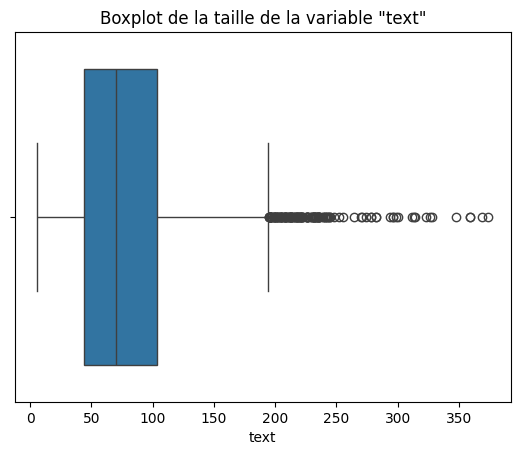

In [ ]:
tmp=data_txt.text.str.len()
sns.boxplot(x = tmp, orient = 'h')
plt.title(f'Boxplot de la taille de la variable "text"')
plt.show()

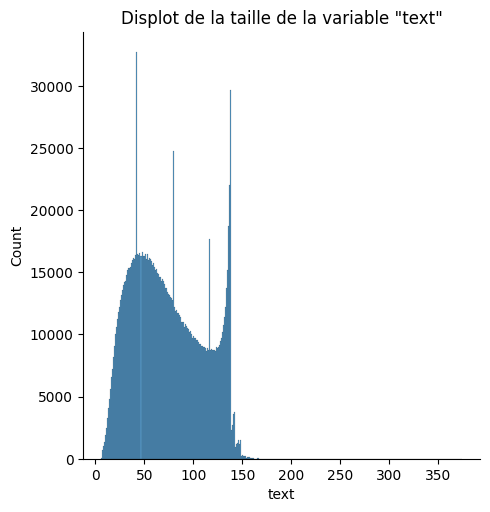

In [ ]:
sns.displot(tmp)
plt.title(f'Displot de la taille de la variable "text"')
plt.show()

Peu de textes ont une taille supérieure à 150 caractères.

Ajoutons la taille au dataframe :

In [ ]:
data_txt['len_text'] = tmp
data_txt

,target,text,len_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
1,0,is upset that he can't update his Facebook by ...,111
2,0,@Kenichan I dived many times for the ball. Man...,89
3,0,my whole body feels itchy and like its on fire,47
4,0,"@nationwideclass no, it's not behaving at all....",111
...,...,...,...
1599995,1,Just woke up. Having no school is the best fee...,56
1599996,1,TheWDB.com - Very cool to hear old Walt interv...,78
1599997,1,Are you ready for your MoJo Makeover? Ask me f...,57
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...,65


## Analyse exploratoire multivariée :


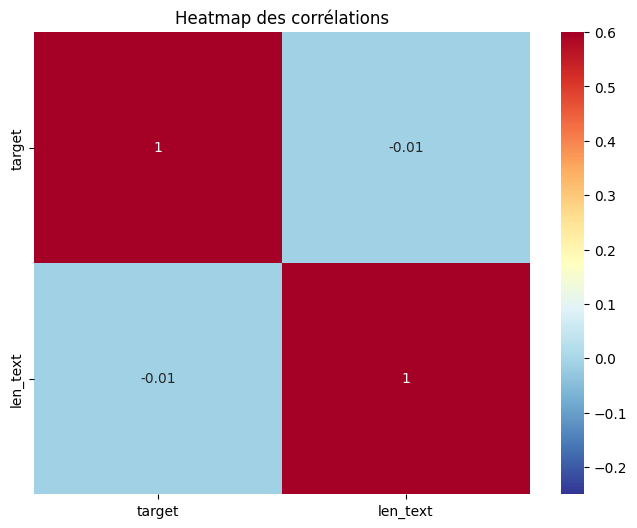

In [ ]:
encoder = LabelEncoder()

# # Encodage de la variable cat_niv_1
data_txt['target'] = encoder.fit_transform(data_txt['target'])

plt.figure(figsize = (8, 6))

# Sélection des colonnes numériques
data_corr = data_txt.select_dtypes(include=['int64', 'int32'])

# Heatmap des correlations
sns.heatmap(data_corr.corr(),
            cmap = plt.cm.RdYlBu_r,
            vmin = -0.25,
            vmax = 0.6,
            annot = True)
plt.title('Heatmap des corrélations')
plt.show()

Il apparait qu'il n'existe pas de corrélation entre la taille des tweets et leur sentiment positif ou négatif.

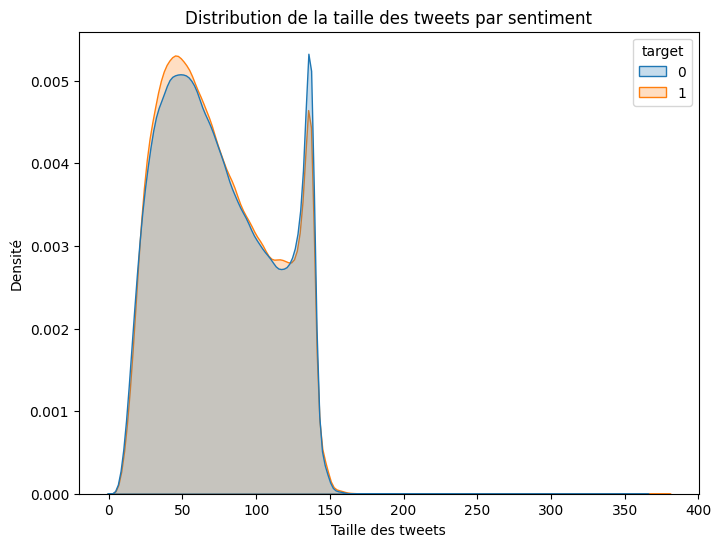

In [ ]:
plt.figure(figsize = (8, 6))
sns.kdeplot( x = 'len_text', hue = 'target', data = data_txt, fill = True)
plt.title('Distribution de la taille des tweets par sentiment')
plt.xlabel('Taille des tweets')
plt.ylabel('Densité')
plt.show()

Les distributions des tailles des tweets sont quasiment identiques qu'ils soient positifs ou négatifs.



## Traitement des données de la variable "text" :

### Pre-processing spécifique des tweets

In [ ]:
# Préprocessing des tweets avec l'algo tweet processorpour ne garder que le texte et les hashtags
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY, p.OPT.MENTION)
data_txt['tweet_preprocess'] = data_txt['text'].apply(p.clean)
data_txt.to_csv('D:/tutorial-env/OCR/Projet7/csv_p7_tweet_preprocess.csv', index=False)

data_txt

,target,text,len_text,tweet_preprocess
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115,"- Awww, that's a bummer. You shoulda got David..."
1,0,is upset that he can't update his Facebook by ...,111,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,89,I dived many times for the ball. Managed to sa...
3,0,my whole body feels itchy and like its on fire,47,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",111,"no, it's not behaving at all. i'm mad. why am ..."
...,...,...,...,...
1599995,1,Just woke up. Having no school is the best fee...,56,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...,78,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...,57,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...,65,Happy 38th Birthday to my boo of alll time!!! ...


### Recherche de la meilleure tokenisation

In [ ]:
# Sélection de 10 descriptions au hasard :
txt = []
for i in range (0, 10) :
     txt.append(data_txt['tweet_preprocess'].sample(1).values[0].lower())
display(txt)

['just got back from the hospital, some man was telling me how hes just been told he has days to live i feel really sad now rofl',
 'wants a latte and bagel',
 'have to be up early in the am for work... sweet crappy weather ahead = little business it needs to clear up sooon!!',
 "ahahaha he's always 4gotten... he prolly got the arm of the chair cuz he got called in2 the interview last.. poor brian lol",
 "i'm sad we don't test together.",
 'good morning twitter world i wish i could go back to bed lol',
 'omd (kevin) pls answer me ugh! i hate to beg',
 'comon man! you know this is saudiyah, your home town! &quot;insha-allah&quot; means when we get around to it!',
 'well it seems the cemetary is a no go',
 'we need to win some fuzzibunz they are what we use at night']

In [ ]:
# Initialisation de la liste de stopwords anglais
stopwords = stopwords.words('english')

# Test de différentes tokenisations :
# le Word Tokenizer se base sur les espaces, le WordPunctTokenizer tient compte de la ponctuation et le RegexpTokenizer utilise des expressions régulières pour une segmentation plus flexible.
for i, doc in enumerate(txt):

    print('**'*50)
    print(f'---> doc_{i}\n')

    # Test de la tokenisation via word_tokenize avec filtrage des stops_words :
    print('Résultat avec word_tokenizer : \n')
    token = word_tokenize(doc)
    token = [w for w in token if w not in stopwords]
    print(len(token), len(set(token)))

    # Test de la tokenisation via wordpunct_tokenize avec filtrage des stops_words :
    print('--'*20)
    print('Résultat avec wordpunct_tokenize : \n')
    token = wordpunct_tokenize(doc)
    token = [w for w in token if w not in stopwords]
    print(len(token), len(set(token)))

    # Test de la tokenisation via RegexpTokenizer avec filtrage des stops_words :
    print('--'*20)
    print('Résultat avec RegexpTokenizer : \n')
    token = RegexpTokenizer(r'\w+').tokenize(doc) # ici le tokenizer ignore la ponctuation et sépare les mots en utilisant uniquement les caractères alphanumériques et le caractère de soulignement
    token = [w for w in token if w not in stopwords]
    print(len(token), len(set(token)))

****************************************************************************************************
---> doc_0

Résultat avec word_tokenizer : 

14 14
----------------------------------------
Résultat avec wordpunct_tokenize : 

14 14
----------------------------------------
Résultat avec RegexpTokenizer : 

13 13
****************************************************************************************************
---> doc_1

Résultat avec word_tokenizer : 

3 3
----------------------------------------
Résultat avec wordpunct_tokenize : 

3 3
----------------------------------------
Résultat avec RegexpTokenizer : 

3 3
****************************************************************************************************
---> doc_2

Résultat avec word_tokenizer : 

15 14
----------------------------------------
Résultat avec wordpunct_tokenize : 

14 14
----------------------------------------
Résultat avec RegexpTokenizer : 

11 11
*******************************************************

La meilleure tokenisation est effectuée via RegexpTokenizer car c'est celui qui amène au minimum de token.

### Liste des stopwords

In [ ]:
# Fonction basique de pré-processing
def preprocess (txt: str,
                stopwords: list,
                n_gram_range = (1,3)) -> list :
  '''Pre-processing d'un texte (lower, tokenisation, suppression des stopwords)
   Args:
        txt (str): Texte à tokeniser
        stopwords (list): Liste de stopwords à supprimer
        n_gram_range (tuple): Niveau des n-grammes à créer par défaut bigramme et trigramme
  Sortie:
        Liste de tokens du texte sans stopwords
  '''
  # lower
  txt = txt.lower().strip()

  # tokenisation
  tokeniser = RegexpTokenizer(r'\w+')
  token = tokeniser.tokenize(txt)

  # suppression des stopwords
  token_clean = [w for w in token if w not in stopwords]

  # Gestion des bi et tri-grammes
  ngram = []
  for n in range(n_gram_range[0], n_gram_range[1] + 1):
    ngram += [' '.join(gram) for gram in ngrams(token_clean, n)]

  return ngram

In [ ]:
# Fusion de tout le corpus
corpus = " ".join( data_txt['tweet_preprocess'].values)
print(len(corpus))

# Tokenisation sur tout le corpus
corpus_tokenised = preprocess(corpus, stopwords)
print(f"Il y a  {len(corpus_tokenised)} tokens.\n"
           f"Il y a  {len(set(corpus_tokenised))} tokens uniques.")

106031620
Il y a  34102524 tokens.
Il y a  15259157 tokens uniques.


In [ ]:
tmp = pd.Series(corpus_tokenised).value_counts()
tmp.head(50)

good        90091
day         85851
get         81720
like        78320
go          73408
today       67843
quot        64999
love        64350
going       64160
work        63649
got         60858
lol         59196
time        57597
back        56374
u           55562
one         53612
know        51924
im          51294
really      49676
amp         47785
see         46094
night       43436
still       43375
2           42761
well        42559
new         42205
want        41909
think       41253
thanks      40273
home        39978
oh          39531
much        36890
miss        35986
need        35661
last        35619
tomorrow    33930
hope        33809
morning     33630
great       33427
3           32540
twitter     32206
haha        31436
feel        29965
sad         29265
fun         28563
wish        28153
right       27826
sleep       27789
would       27262
bad         27142
Name: count, dtype: int64

Il pourrait être intéressant d'enlever les tokens les plus fréquents ( > 65000).


Cependant, il apparait que les mots de moins de 3 caractères n'ont pas l'air pertinents pour notre classification.

In [ ]:
tmp.tail(50)

cause thursday oh              1
keep alive forever             1
alive forever good             1
forever good said              1
good said peta                 1
said peta bread                1
peta bread bla                 1
bread bla school               1
bla school gonna               1
gonna boring cause             1
boring cause thursday          1
sad day cause                  1
noooo kill keep                1
day cause raining              1
cause raining erie             1
raining erie pa                1
erie pa danny                  1
pa danny went                  1
went home must                 1
home must rain                 1
must rain every                1
time sigh company              1
sigh company firewall          1
kill keep alive                1
moi noooo kill                 1
night full bad                 1
today minus okay               1
full bad dreams                1
bad dreams leave               1
dreams leave one               1
leave one 

In [ ]:
tmp.describe()

count    1.525916e+07
mean     2.234889e+00
std      1.070944e+02
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      9.009100e+04
Name: count, dtype: float64

In [ ]:
stopword_liste = list(stopwords)
temp = tmp[:7].index
for i, word in enumerate (temp):
  stopword_liste.append(word)

with open('D:/tutorial-env/OCR/Projet7/_stopword_liste.json', 'w') as f:
  json.dump(stopword_liste, f)


Plus de 75% des tokens ne sont présents qu'une ou deux fois ce qui parait peu pertinents pour une classification.


On décide donc de ne pas garder :
- les tokens qui n'apparaissent qu'une fois,
- les 6 tokens les plus fréquents,
- les tokens de moins de 3 caractères,
- les tokens non alphabétiques

car ils ne seront pas pertinents pour notre classification.

### Fonction de pré-processing

In [ ]:
def preprocessing (txt: str,
                stopwords: list,
                freq_min: int,
                freq_max: int,
                min_car: int,
                n_gram_range = (1,3),
                alpha_car = True,
                stem_lemm = "stem") -> list :
  '''Pre-processing d'un texte (lower, tokenisation, suppression des stopwords)
   Args:
        txt (str): Texte à tokeniser
        stopwords (list): Liste de stopwords à supprimer
        freq_min (int): Fréquence minimale des tokens à garder
        freq_max (int): Fréquence maximale des tokens à garder
        min_car (int): Longueur minimale des tokens à garder
        n_gram_range (tuple): Niveau des n-grammes à créer par défaut bigramme et trigramme
        alpha_car (bool): Si True, ne garde que les tokens contenant uniquement des lettres
        stem_lemm (str): Si "stem", stemmatise les tokens, si "lemm" lemmatises les tokens
  Sortie:
        Liste de tokens du texte sans stopwords et filtrer selon les arguments entrés
  '''
  # lower
  txt = txt.lower().strip()

  # tokenisation
  tokeniser = RegexpTokenizer(r'\w+')
  token = tokeniser.tokenize(txt)

  # suppression des stopwords
  token_clean = [w for w in token if w not in stopwords]

  # filtrage selon la longueur min
  token_clean = [w for w in token_clean if len(w) >= min_car]

  # filtrage selon les caractères alphabétiques
  if alpha_car == True:
    token_clean = [w for w in token_clean if w.isalpha()  or ' ' in w]

  # Gestion des bi et tri-grammes
  ngram = []
  for n in range(n_gram_range[0], n_gram_range[1] + 1):
    ngram += ['_'.join(gram) for gram in ngrams(token_clean, n)]

  # filtrage selon la fréquence min et max
  token_counts = Counter(ngram)
  token_clean = [w for w in ngram if freq_min<=token_counts[w]<=freq_max]

  # Stemming ou lematisation
  if stem_lemm == "stem":
    transf = PorterStemmer()
    token_clean = [transf.stem(w) for w in token_clean]
  if stem_lemm == "lemm":
    transf = WordNetLemmatizer()
    token_clean = [transf.lemmatize(w) for w in token_clean]
  else:
    pass

  return token_clean

In [ ]:
# Nouvelle tokenisation sur tout le corpus
corpus_tokenised_stem = preprocessing(corpus, stopword_liste, 2, 200000, 3, stem_lemm = "stem")
print(f"Il y a  {len(corpus_tokenised_stem)} tokens.\n"
           f"Il y a  {len(set(corpus_tokenised_stem))} tokens uniques.")

Il y a  17454028 tokens.
Il y a  1325228 tokens uniques.


In [ ]:
# Nouvelle tokenisation sur tout le corpus
corpus_tokenised_lemm = preprocessing(corpus, stopword_liste, 2, 200000, 3, stem_lemm = "lemm")
print(f"Il y a  {len(corpus_tokenised_lemm)} tokens.\n"
           f"Il y a  {len(set(corpus_tokenised_lemm))} tokens uniques.")

Il y a  17454028 tokens.
Il y a  1456221 tokens uniques.


Le stemming est le plus efficace pour diminuer le nombre de tokens unique.

### Visualisation des tokens du corpus pré-traité

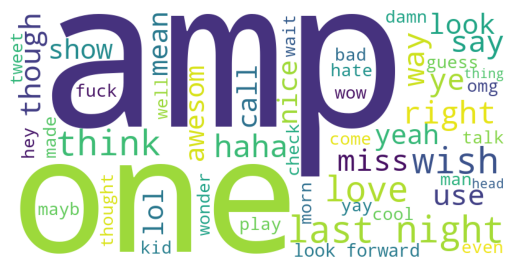

In [ ]:
wordcloud = WordCloud(
    width = 800, height = 400,
    background_color ='white', max_words = 50
    ).generate(" ".join(corpus_tokenised_stem))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Visualisation des tokens du corpus pré-traité selon les catégories

In [ ]:
#Séparation du dataframe en fonction des catégories :

data_txt_0 = data_txt[data_txt['target'] == 0]
data_txt_1 = data_txt[data_txt['target'] == 1]


In [ ]:
#Création des différents corpus par catégories
corpus_0 = " ".join( data_txt_0.tweet_preprocess)
corpus_1 = " ".join( data_txt_1.tweet_preprocess)

In [ ]:
# Tokenisation des différents corpus par catégories
for i in range (0,2) :
  name_corpus = f"corpus_{i}"
  name_corpus_tokenised = f"corpus_tokenised_{i}"
  globals()[name_corpus_tokenised] = preprocessing(globals()[name_corpus], stopword_liste, 2, 200000, 3, stem_lemm = "stem")
  print(f"Dans {name_corpus} : \n"
        f"Il y a  {len( globals()[name_corpus_tokenised])} tokens.\n"
        f"Il y a  {len(set( globals()[name_corpus_tokenised]))} tokens uniques.\n"
        f"***************************************************************")

Dans corpus_0 : 
Il y a  8653554 tokens.
Il y a  700326 tokens uniques.
***************************************************************
Dans corpus_1 : 
Il y a  8004659 tokens.
Il y a  633132 tokens uniques.
***************************************************************


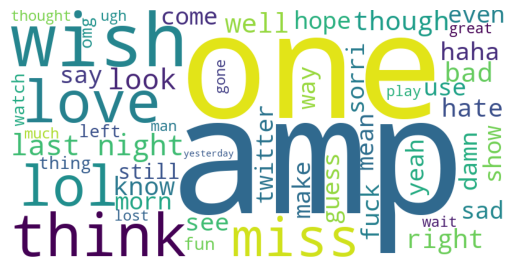

In [ ]:
#  Visualisation des tokens de la catégorie 0 (sentiment négatif)
wordcloud = WordCloud(
    width = 800, height = 400,
    background_color ='white', max_words = 50
    ).generate(" ".join(corpus_tokenised_0))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

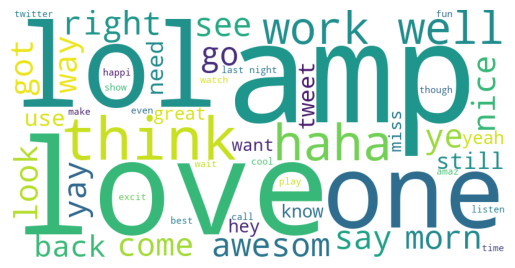

In [ ]:
#  Visualisation des tokens de la catégorie 1 (sentiment positif)
wordcloud = WordCloud(
    width = 800, height = 400,
    background_color ='white', max_words = 50
    ).generate(" ".join(corpus_tokenised_1))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Nettoyage final

In [ ]:
# fonction pour filtrer les tokens
def filter_tokens(tokens: list,
                  corpus: list) -> list :
  '''Filtrage d'une liste de tokens en fonction d'une liste référente de tokens
   Args:
        tokens (list): Liste de tokens à comparer
        corpus (list): Liste de tokens référente
  Sortie:
        Liste de tokens filtrés
  '''
  return [token for token in tokens if token in corpus_set]

In [ ]:
data_txt_sample_0 = data_txt[data_txt['target'] == 0].sample(n=100000, random_state=42)
data_txt_sample_0

,target,text,len_text,tweet_preprocess
797724,0,my ipod can stop this restore to factory setti...,76,my ipod can stop this restore to factory setti...
723288,0,headache!!!! waaaaaaaa,23,headache!!!! waaaaaaaa
413887,0,I'm going to bed and sleeping in tomorrow morn...,107,I'm going to bed and sleeping in tomorrow morn...
580748,0,"it's the same old song, but with a different m...",80,"it's the same old song, but with a different m..."
539577,0,@weezyREBEL i didnt finish watching it the web...,121,i didnt finish watching it the website kept ma...
...,...,...,...,...
372640,0,I hate babysitting. I hate children. I hate ye...,133,I hate babysitting. I hate children. I hate ye...
267723,0,@Jack_Palahniuk I would say yay for we have an...,101,I would say yay for we have another thing in c...
502734,0,@saulyoung sad day. But lauren is asleep now....,127,sad day. But lauren is asleep now...the dance ...
306775,0,@mitchelmusso omg! r songs r awesome! i love t...,121,omg! r songs r awesome! i love them! i cant bu...


In [ ]:
data_txt_sample_1 = data_txt[data_txt['target'] == 1].sample(n=100000, random_state=42)
data_txt_sample_1

,target,text,len_text,tweet_preprocess
1569660,1,Asshole!!! Its time for a bubble bath,38,Asshole!!! Its time for a bubble bath
896671,1,really hoping the homemade soup enough to take...,137,really hoping the homemade soup enough to take...
1491533,1,@Sundinska Your mail has been forwarded!,41,Your mail has been forwarded!
1555710,1,first time ive even gotten a gift at someone e...,58,first time ive even gotten a gift at someone e...
1274077,1,"@mikeymcfly luv u, per usual. have great ment...",76,"luv u, per usual. have great mental day off 2m..."
...,...,...,...,...
889698,1,@KendellRenee Anytime,22,Anytime
969700,1,I love rainy days!!!!,22,I love rainy days!!!!
804636,1,@yogadork our barefoot range is a great altern...,134,our barefoot range is a great alternative when...
1497384,1,ok off to bed good night everyone,34,ok off to bed good night everyone


In [ ]:
df_sample = pd.concat([data_txt_sample_0, data_txt_sample_1], ignore_index=True)
df_sample

,target,text,len_text,tweet_preprocess
0,0,my ipod can stop this restore to factory setti...,76,my ipod can stop this restore to factory setti...
1,0,headache!!!! waaaaaaaa,23,headache!!!! waaaaaaaa
2,0,I'm going to bed and sleeping in tomorrow morn...,107,I'm going to bed and sleeping in tomorrow morn...
3,0,"it's the same old song, but with a different m...",80,"it's the same old song, but with a different m..."
4,0,@weezyREBEL i didnt finish watching it the web...,121,i didnt finish watching it the website kept ma...
...,...,...,...,...
199995,1,@KendellRenee Anytime,22,Anytime
199996,1,I love rainy days!!!!,22,I love rainy days!!!!
199997,1,@yogadork our barefoot range is a great altern...,134,our barefoot range is a great alternative when...
199998,1,ok off to bed good night everyone,34,ok off to bed good night everyone


In [ ]:
# Séparation données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(
    df_sample,
    df_sample.target,
    test_size=0.2,
    random_state=42,
)

# Séparation données d'entrainement et de validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42,
)

In [ ]:
X_train.to_csv('D:/tutorial-env/OCR/Projet7/csv_p7_Xtrain.csv', index=False)
X_val.to_csv('D:/tutorial-env/OCR/Projet7/csv_p7_Xval.csv', index=False)
X_test.to_csv('D:/tutorial-env/OCR/Projet7/csv_p7_Xtest.csv', index=False)

In [ ]:
# Appliquer preprocessing à chaque ligne du dataframe d'entrainement (en ne filtrant pas sur la fréquence)
X_train['token_by_tweet_temp'] = X_train.tweet_preprocess.apply(lambda txt: preprocessing(txt, stopword_liste, 1, 200000, 3, stem_lemm="stem"))
X_train

,target,text,len_text,tweet_preprocess,token_by_tweet_temp
91244,0,Its a Blood red half moon. A beatle Landed on ...,120,Its a Blood red half moon. A beatle Landed on ...,"[blood, red, half, moon, beatl, land, saint, c..."
27737,0,I'm so tense today I genuinely fear spontaneou...,138,I'm so tense today I genuinely fear spontaneou...,"[tens, genuin, fear, spontan, combust, left, s..."
49723,0,Is doing revision...AGAIN!!,28,Is doing revision...AGAIN!!,[revis]
190935,1,@manuanya it just. *squishes* reminds me of ou...,98,it just. *squishes* reminds me of our glorious...,"[squish, remind, gloriou, media, room, comfi, ..."
105993,1,watching letterman and talking,31,watching letterman and talking,"[watch, letterman, talk, watching_letterman, l..."
...,...,...,...,...,...
115145,1,"@Dannabug A) MINIS! B) awesome, i'll let you ...",115,"A) MINIS! B) awesome, i'll let you know if i d...","[mini, awesom, let, know, find, anyon, around,..."
128356,1,Bout to KNOCK the F*CK out ... Have a great ni...,56,Bout to KNOCK the F*CK out ... Have a great ni...,"[bout, knock, great, night, folk, bout_knock, ..."
186557,1,"So tired don't think I even had 6 hours,8 days...",51,"So tired don't think I even had 6 hours,8 days...","[tire, think, even, hour, daysssss, tired_thin..."
34364,0,@kyliad mythics... can't queue as a wb any mor...,112,mythics... can't queue as a wb any more so it ...,"[mythic, queue, becam, big, pug, fest, know, w..."


In [ ]:
# Appliquer preprocessing à chaque ligne du dataframe de test (en ne filtrant pas sur la fréquence)
X_val['token_by_tweet_temp'] = X_val.tweet_preprocess.apply(lambda txt: preprocessing(txt, stopword_liste, 1, 200000, 3, stem_lemm="stem"))
X_val

,target,text,len_text,tweet_preprocess,token_by_tweet_temp
186378,1,I wanna in queue 2! I even registered 2 buy it...,74,I wanna in queue 2! I even registered 2 buy it...,"[wanna, queue, even, regist, buy, howev, forgo..."
1897,0,So no-one is coming with me Damn..,35,So no-one is coming with me Damn..,"[one, come, damn, one_com, coming_damn, one_co..."
59565,0,@dmbdork live and learn screw you Stanley Ste...,56,live and learn screw you Stanley Steemer!!!,"[live, learn, screw, stanley, steemer, live_le..."
127367,1,I want to watch fight club with u!,35,I want to watch fight club with u!,"[want, watch, fight, club, want_watch, watch_f..."
159558,1,10 more CD's and then I'm done the good new al...,126,10 more CD's and then I'm done the good new al...,"[done, new, album, upload, new, macbook, gone,..."
...,...,...,...,...,...
58776,0,@jakkijax It's been lovely but I've managed to...,138,It's been lovely but I've managed to be Ill th...,"[love, manag, ill, jealou, go, plan, trip, you..."
45869,0,my Netflix DVD must be lost in the mail. I wa...,110,my Netflix DVD must be lost in the mail. I was...,"[netflix, dvd, must, lost, mail, look, forward..."
1834,0,The Taxi Q at Pelangi was super loooong.. and ...,107,The Taxi Q at Pelangi was super loooong.. and ...,"[taxi, pelangi, super, loooong, get, headach, ..."
13950,0,"I feel really quite sick, so hae had to skip B...",135,"I feel really quite sick, so hae had to skip B...","[feel, realli, quit, sick, hae, skip, book, re..."


In [ ]:
# Appliquer preprocessing à chaque ligne du dataframe de test (en ne filtrant pas sur la fréquence)
X_test['token_by_tweet_temp'] = X_test.tweet_preprocess.apply(lambda txt: preprocessing(txt, stopword_liste, 1, 200000, 3, stem_lemm="stem"))
X_test

,target,text,len_text,tweet_preprocess,token_by_tweet_temp
119737,1,@brandireland that's good... for me ;) may go ...,131,that's good... for me may go tomo/mon. loose e...,"[may, tomo, mon, loos, end, prob, go, wander, ..."
72272,0,@msdivineknight Don't know...When I went to hi...,95,Don't know...When I went to his twitter page i...,"[know, went, twitter, page, say, exist, bummer..."
158154,1,@SerendipityJane Thank you and good morning Ja...,80,Thank you and good morning Jane ... Have a won...,"[thank, morn, jane, wonder, sunday, thank_morn..."
65426,0,Times like this when I hate being sick. I need...,134,Times like this when I hate being sick. I need...,"[time, hate, sick, need, want, sleep, cough, m..."
30074,0,Killing time through pointlism/stippling.,42,Killing time through pointlism/stippling.,"[kill, time, pointlism, stippl, killing_tim, t..."
...,...,...,...,...,...
4174,0,not going back. Got sick while trying to get ...,104,not going back. Got sick while trying to get r...,"[go, back, got, sick, tri, readi, realli, want..."
91537,0,The river is so cold.,22,The river is so cold.,"[river, cold, river_cold]"
156449,1,Haha but you know what? nothing better than go...,115,Haha but you know what? nothing better than go...,"[haha, know, noth, better, old, dial, internet..."
184376,1,@prempanicker In one way it's good that we los...,125,In one way it's good that we lost the match. A...,"[one, way, lost, match, atleast, concentr, wor..."


In [ ]:
# conversion du corpus en un set pour limiter les coûts mémoire
corpus_set = set(corpus_tokenised_stem)


In [ ]:
# Filtrer token de chaque ligne du dataframe d'entrainement en fonction de la liste de tokens trouvés avec preprocessing sur tout le corpus
X_train['token_by_tweet_finalised'] = X_train.token_by_tweet_temp.apply(lambda txt: filter_tokens(txt, corpus_set))
X_train

,target,text,len_text,tweet_preprocess,token_by_tweet_temp,token_by_tweet_finalised
91244,0,Its a Blood red half moon. A beatle Landed on ...,120,Its a Blood red half moon. A beatle Landed on ...,"[blood, red, half, moon, beatl, land, saint, c...","[blood, red, half, moon, beatl, land, saint, m..."
27737,0,I'm so tense today I genuinely fear spontaneou...,138,I'm so tense today I genuinely fear spontaneou...,"[tens, genuin, fear, spontan, combust, left, s...","[tens, genuin, fear, spontan, combust, left, s..."
49723,0,Is doing revision...AGAIN!!,28,Is doing revision...AGAIN!!,[revis],[revis]
190935,1,@manuanya it just. *squishes* reminds me of ou...,98,it just. *squishes* reminds me of our glorious...,"[squish, remind, gloriou, media, room, comfi, ...","[squish, remind, gloriou, media, room, comfi, ..."
105993,1,watching letterman and talking,31,watching letterman and talking,"[watch, letterman, talk, watching_letterman, l...","[watch, letterman, talk, watching_letterman]"
...,...,...,...,...,...,...
115145,1,"@Dannabug A) MINIS! B) awesome, i'll let you ...",115,"A) MINIS! B) awesome, i'll let you know if i d...","[mini, awesom, let, know, find, anyon, around,...","[mini, awesom, let, know, find, anyon, around,..."
128356,1,Bout to KNOCK the F*CK out ... Have a great ni...,56,Bout to KNOCK the F*CK out ... Have a great ni...,"[bout, knock, great, night, folk, bout_knock, ...","[bout, knock, great, night, folk, bout_knock, ..."
186557,1,"So tired don't think I even had 6 hours,8 days...",51,"So tired don't think I even had 6 hours,8 days...","[tire, think, even, hour, daysssss, tired_thin...","[tire, think, even, hour, daysssss, tired_thin..."
34364,0,@kyliad mythics... can't queue as a wb any mor...,112,mythics... can't queue as a wb any more so it ...,"[mythic, queue, becam, big, pug, fest, know, w...","[mythic, queue, becam, big, pug, fest, know, w..."


In [ ]:
# Comptons le nombre de tokens unique
all_tokens_train = [token for tokens in X_train['token_by_tweet_finalised'] for token in tokens]
with open('D:/tutorial-env/OCR/Projet7/all_tokens_train.json', 'w') as f:
  json.dump(all_tokens_train, f)

unique_word_count_train = len(set(all_tokens_train))
unique_word_count_train

340038

In [ ]:
# Filtrer token de chaque ligne du dataframe d'entrainement en fonction de la liste de tokens trouvés avec preprocessing sur tout le corpus
X_val['token_by_tweet_finalised'] = X_val.token_by_tweet_temp.apply(lambda txt: filter_tokens(txt, corpus_set))
X_val

,target,text,len_text,tweet_preprocess,token_by_tweet_temp,token_by_tweet_finalised
186378,1,I wanna in queue 2! I even registered 2 buy it...,74,I wanna in queue 2! I even registered 2 buy it...,"[wanna, queue, even, regist, buy, howev, forgo...","[wanna, queue, even, regist, buy, howev, forgo..."
1897,0,So no-one is coming with me Damn..,35,So no-one is coming with me Damn..,"[one, come, damn, one_com, coming_damn, one_co...","[one, come, damn, one_com, coming_damn]"
59565,0,@dmbdork live and learn screw you Stanley Ste...,56,live and learn screw you Stanley Steemer!!!,"[live, learn, screw, stanley, steemer, live_le...","[live, learn, screw, stanley, steemer, live_le..."
127367,1,I want to watch fight club with u!,35,I want to watch fight club with u!,"[want, watch, fight, club, want_watch, watch_f...","[want, watch, fight, club, want_watch, watch_f..."
159558,1,10 more CD's and then I'm done the good new al...,126,10 more CD's and then I'm done the good new al...,"[done, new, album, upload, new, macbook, gone,...","[done, new, album, upload, new, macbook, gone,..."
...,...,...,...,...,...,...
58776,0,@jakkijax It's been lovely but I've managed to...,138,It's been lovely but I've managed to be Ill th...,"[love, manag, ill, jealou, go, plan, trip, you...","[love, manag, ill, jealou, go, plan, trip, you..."
45869,0,my Netflix DVD must be lost in the mail. I wa...,110,my Netflix DVD must be lost in the mail. I was...,"[netflix, dvd, must, lost, mail, look, forward...","[netflix, dvd, must, lost, mail, look, forward..."
1834,0,The Taxi Q at Pelangi was super loooong.. and ...,107,The Taxi Q at Pelangi was super loooong.. and ...,"[taxi, pelangi, super, loooong, get, headach, ...","[taxi, pelangi, super, loooong, get, headach, ..."
13950,0,"I feel really quite sick, so hae had to skip B...",135,"I feel really quite sick, so hae had to skip B...","[feel, realli, quit, sick, hae, skip, book, re...","[feel, realli, quit, sick, hae, skip, book, re..."


In [ ]:
# Comptons le nombre de tokens unique
all_tokens_val = [token for tokens in X_val['token_by_tweet_finalised'] for token in tokens]
with open('D:/tutorial-env/OCR/Projet7/all_tokens_val.json', 'w') as f:
  json.dump(all_tokens_val, f)

unique_word_count_val = len(set(all_tokens_val))
unique_word_count_val

118011

In [ ]:
# Filtrer token de chaque ligne du dataframe de test en fonction de la liste de tokens trouvés avec preprocessing sur tout le corpus
X_test['token_by_tweet_finalised'] = X_test.token_by_tweet_temp.apply(lambda txt: filter_tokens(txt, corpus_set))
X_test

,target,text,len_text,tweet_preprocess,token_by_tweet_temp,token_by_tweet_finalised
119737,1,@brandireland that's good... for me ;) may go ...,131,that's good... for me may go tomo/mon. loose e...,"[may, tomo, mon, loos, end, prob, go, wander, ...","[may, tomo, mon, loos, end, prob, go, wander, ..."
72272,0,@msdivineknight Don't know...When I went to hi...,95,Don't know...When I went to his twitter page i...,"[know, went, twitter, page, say, exist, bummer...","[know, went, twitter, page, say, exist, bummer..."
158154,1,@SerendipityJane Thank you and good morning Ja...,80,Thank you and good morning Jane ... Have a won...,"[thank, morn, jane, wonder, sunday, thank_morn...","[thank, morn, jane, wonder, sunday, thank_morn..."
65426,0,Times like this when I hate being sick. I need...,134,Times like this when I hate being sick. I need...,"[time, hate, sick, need, want, sleep, cough, m...","[time, hate, sick, need, want, sleep, cough, m..."
30074,0,Killing time through pointlism/stippling.,42,Killing time through pointlism/stippling.,"[kill, time, pointlism, stippl, killing_tim, t...","[kill, time, stippl, killing_tim]"
...,...,...,...,...,...,...
4174,0,not going back. Got sick while trying to get ...,104,not going back. Got sick while trying to get r...,"[go, back, got, sick, tri, readi, realli, want...","[go, back, got, sick, tri, readi, realli, want..."
91537,0,The river is so cold.,22,The river is so cold.,"[river, cold, river_cold]","[river, cold]"
156449,1,Haha but you know what? nothing better than go...,115,Haha but you know what? nothing better than go...,"[haha, know, noth, better, old, dial, internet...","[haha, know, noth, better, old, dial, internet..."
184376,1,@prempanicker In one way it's good that we los...,125,In one way it's good that we lost the match. A...,"[one, way, lost, match, atleast, concentr, wor...","[one, way, lost, match, atleast, concentr, wor..."


In [ ]:
# Comptons le nombre de tokens unique
all_tokens_test = [token for tokens in X_test['token_by_tweet_finalised'] for token in tokens]
with open('D:/tutorial-env/OCR/Projet7/all_tokens_test.json', 'w') as f:
  json.dump(all_tokens_test, f)

unique_word_count_test = len(set(all_tokens_test))
unique_word_count_test

141014

### Nettoyage final sans racinisation

pour les algorithmes pré-entrainés sans racinisation au préalable

In [ ]:
def preprocessing_sans_racinisation (txt: str,
                stopwords: list,
                freq_min: int,
                freq_max: int,
                min_car: int,
                n_gram_range = (1,3),
                alpha_car = True) -> list :
  '''Pre-processing d'un texte (lower, tokenisation, suppression des stopwords)
   Args:
        txt (str): Texte à tokeniser
        stopwords (list): Liste de stopwords à supprimer
        freq_min (int): Fréquence minimale des tokens à garder
        freq_max (int): Fréquence maximale des tokens à garder
        min_car (int): Longueur minimale des tokens à garder
        n_gram_range (tuple): Niveau des n-grammes à créer par défaut bigramme et trigramme
        alpha_car (bool): Si True, ne garde que les tokens contenant uniquement des lettres
  Sortie:
        Liste de tokens du texte sans stopwords et filtrer selon les arguments entrés
  '''
  # lower
  txt = txt.lower().strip()

  # tokenisation
  tokeniser = RegexpTokenizer(r'\w+')
  token = tokeniser.tokenize(txt)
  # token = [w.strip() for w in token]

  # suppression des stopwords
  token_clean = [w for w in token if w not in stopwords]

  # filtrage selon la longueur min
  token_clean = [w for w in token_clean if len(w) >= min_car]

  # filtrage selon les caractères alphabétiques
  if alpha_car == True:
    token_clean = [w for w in token_clean if w.isalpha()  or ' ' in w]

  # Gestion des bi et tri-grammes
  ngram = []
  for n in range(n_gram_range[0], n_gram_range[1] + 1):
    ngram += ['_'.join(gram) for gram in ngrams(token_clean, n)]

  # filtrage selon la fréquence min et max
  token_counts = Counter(ngram)
  token_clean = [w for w in ngram if freq_min<=token_counts[w]<=freq_max]

  return token_clean

In [ ]:
# Appliquer preprocessing_sans_racinisation à chaque ligne du dataframe d'entrainement (en ne filtrant pas sur la fréquence)
X_train['token_by_tweet_temp_sans_racinisation'] = X_train.tweet_preprocess.apply(lambda txt: preprocessing_sans_racinisation(txt, stopword_liste, 1, 200000, 3))
X_train

,target,text,len_text,tweet_preprocess,token_by_tweet_temp,token_by_tweet_finalised,token_by_tweet_temp_sans_racinisation
91244,0,Its a Blood red half moon. A beatle Landed on ...,120,Its a Blood red half moon. A beatle Landed on ...,"[blood, red, half, moon, beatl, land, saint, c...","[blood, red, half, moon, beatl, land, saint, m...","[blood, red, half, moon, beatle, landed, saint..."
27737,0,I'm so tense today I genuinely fear spontaneou...,138,I'm so tense today I genuinely fear spontaneou...,"[tens, genuin, fear, spontan, combust, left, s...","[tens, genuin, fear, spontan, combust, left, s...","[tense, genuinely, fear, spontaneously, combus..."
49723,0,Is doing revision...AGAIN!!,28,Is doing revision...AGAIN!!,[revis],[revis],[revision]
190935,1,@manuanya it just. *squishes* reminds me of ou...,98,it just. *squishes* reminds me of our glorious...,"[squish, remind, gloriou, media, room, comfi, ...","[squish, remind, gloriou, media, room, comfi, ...","[squishes, reminds, glorious, media, room, com..."
105993,1,watching letterman and talking,31,watching letterman and talking,"[watch, letterman, talk, watching_letterman, l...","[watch, letterman, talk, watching_letterman]","[watching, letterman, talking, watching_letter..."
...,...,...,...,...,...,...,...
115145,1,"@Dannabug A) MINIS! B) awesome, i'll let you ...",115,"A) MINIS! B) awesome, i'll let you know if i d...","[mini, awesom, let, know, find, anyon, around,...","[mini, awesom, let, know, find, anyon, around,...","[minis, awesome, let, know, find, anyone, arou..."
128356,1,Bout to KNOCK the F*CK out ... Have a great ni...,56,Bout to KNOCK the F*CK out ... Have a great ni...,"[bout, knock, great, night, folk, bout_knock, ...","[bout, knock, great, night, folk, bout_knock, ...","[bout, knock, great, night, folks, bout_knock,..."
186557,1,"So tired don't think I even had 6 hours,8 days...",51,"So tired don't think I even had 6 hours,8 days...","[tire, think, even, hour, daysssss, tired_thin...","[tire, think, even, hour, daysssss, tired_thin...","[tired, think, even, hours, daysssss, tired_th..."
34364,0,@kyliad mythics... can't queue as a wb any mor...,112,mythics... can't queue as a wb any more so it ...,"[mythic, queue, becam, big, pug, fest, know, w...","[mythic, queue, becam, big, pug, fest, know, w...","[mythics, queue, became, big, pug, fest, know,..."


In [ ]:
# Appliquer preprocessing_sans_racinisation à chaque ligne du dataframe d'entrainement (en ne filtrant pas sur la fréquence)
X_val['token_by_tweet_temp_sans_racinisation'] = X_val.tweet_preprocess.apply(lambda txt: preprocessing_sans_racinisation(txt, stopword_liste, 1, 200000, 3))
X_val

,target,text,len_text,tweet_preprocess,token_by_tweet_temp,token_by_tweet_finalised,token_by_tweet_temp_sans_racinisation
186378,1,I wanna in queue 2! I even registered 2 buy it...,74,I wanna in queue 2! I even registered 2 buy it...,"[wanna, queue, even, regist, buy, howev, forgo...","[wanna, queue, even, regist, buy, howev, forgo...","[wanna, queue, even, registered, buy, however,..."
1897,0,So no-one is coming with me Damn..,35,So no-one is coming with me Damn..,"[one, come, damn, one_com, coming_damn, one_co...","[one, come, damn, one_com, coming_damn]","[one, coming, damn, one_coming, coming_damn, o..."
59565,0,@dmbdork live and learn screw you Stanley Ste...,56,live and learn screw you Stanley Steemer!!!,"[live, learn, screw, stanley, steemer, live_le...","[live, learn, screw, stanley, steemer, live_le...","[live, learn, screw, stanley, steemer, live_le..."
127367,1,I want to watch fight club with u!,35,I want to watch fight club with u!,"[want, watch, fight, club, want_watch, watch_f...","[want, watch, fight, club, want_watch, watch_f...","[want, watch, fight, club, want_watch, watch_f..."
159558,1,10 more CD's and then I'm done the good new al...,126,10 more CD's and then I'm done the good new al...,"[done, new, album, upload, new, macbook, gone,...","[done, new, album, upload, new, macbook, gone,...","[done, new, albums, uploaded, new, macbook, go..."
...,...,...,...,...,...,...,...
58776,0,@jakkijax It's been lovely but I've managed to...,138,It's been lovely but I've managed to be Ill th...,"[love, manag, ill, jealou, go, plan, trip, you...","[love, manag, ill, jealou, go, plan, trip, you...","[lovely, managed, ill, jealous, going, plannin..."
45869,0,my Netflix DVD must be lost in the mail. I wa...,110,my Netflix DVD must be lost in the mail. I was...,"[netflix, dvd, must, lost, mail, look, forward...","[netflix, dvd, must, lost, mail, look, forward...","[netflix, dvd, must, lost, mail, looking, forw..."
1834,0,The Taxi Q at Pelangi was super loooong.. and ...,107,The Taxi Q at Pelangi was super loooong.. and ...,"[taxi, pelangi, super, loooong, get, headach, ...","[taxi, pelangi, super, loooong, get, headach, ...","[taxi, pelangi, super, loooong, getting, heada..."
13950,0,"I feel really quite sick, so hae had to skip B...",135,"I feel really quite sick, so hae had to skip B...","[feel, realli, quit, sick, hae, skip, book, re...","[feel, realli, quit, sick, hae, skip, book, re...","[feel, really, quite, sick, hae, skip, book, r..."


In [ ]:
# Appliquer preprocessing_sans_racinisation à chaque ligne du dataframe de test (en ne filtrant pas sur la fréquence)
X_test['token_by_tweet_temp_sans_racinisation'] = X_test.tweet_preprocess.apply(lambda txt: preprocessing_sans_racinisation(txt, stopword_liste, 1, 200000, 3))
X_test

,target,text,len_text,tweet_preprocess,token_by_tweet_temp,token_by_tweet_finalised,token_by_tweet_temp_sans_racinisation
119737,1,@brandireland that's good... for me ;) may go ...,131,that's good... for me may go tomo/mon. loose e...,"[may, tomo, mon, loos, end, prob, go, wander, ...","[may, tomo, mon, loos, end, prob, go, wander, ...","[may, tomo, mon, loose, end, prob, going, wand..."
72272,0,@msdivineknight Don't know...When I went to hi...,95,Don't know...When I went to his twitter page i...,"[know, went, twitter, page, say, exist, bummer...","[know, went, twitter, page, say, exist, bummer...","[know, went, twitter, page, says, exist, bumme..."
158154,1,@SerendipityJane Thank you and good morning Ja...,80,Thank you and good morning Jane ... Have a won...,"[thank, morn, jane, wonder, sunday, thank_morn...","[thank, morn, jane, wonder, sunday, thank_morn...","[thank, morning, jane, wonderful, sunday, than..."
65426,0,Times like this when I hate being sick. I need...,134,Times like this when I hate being sick. I need...,"[time, hate, sick, need, want, sleep, cough, m...","[time, hate, sick, need, want, sleep, cough, m...","[times, hate, sick, need, want, sleep, coughin..."
30074,0,Killing time through pointlism/stippling.,42,Killing time through pointlism/stippling.,"[kill, time, pointlism, stippl, killing_tim, t...","[kill, time, stippl, killing_tim]","[killing, time, pointlism, stippling, killing_..."
...,...,...,...,...,...,...,...
4174,0,not going back. Got sick while trying to get ...,104,not going back. Got sick while trying to get r...,"[go, back, got, sick, tri, readi, realli, want...","[go, back, got, sick, tri, readi, realli, want...","[going, back, got, sick, trying, ready, really..."
91537,0,The river is so cold.,22,The river is so cold.,"[river, cold, river_cold]","[river, cold]","[river, cold, river_cold]"
156449,1,Haha but you know what? nothing better than go...,115,Haha but you know what? nothing better than go...,"[haha, know, noth, better, old, dial, internet...","[haha, know, noth, better, old, dial, internet...","[haha, know, nothing, better, old, dial, inter..."
184376,1,@prempanicker In one way it's good that we los...,125,In one way it's good that we lost the match. A...,"[one, way, lost, match, atleast, concentr, wor...","[one, way, lost, match, atleast, concentr, wor...","[one, way, lost, match, atleast, concentrate, ..."


In [ ]:
# Nouvelle tokenisation sans racinisation sur tout le corpus
corpus_tokenised_sans_racinisation = preprocessing_sans_racinisation(corpus, stopword_liste, 2, 200000, 3)
print(f"Il y a  {len(corpus_tokenised_sans_racinisation)} tokens.\n"
           f"Il y a  {len(set(corpus_tokenised_sans_racinisation))} tokens uniques.")

Il y a  17454028 tokens.
Il y a  1465217 tokens uniques.


In [ ]:
# convertion du corpus en un set pour limiter les coûts mémoire
corpus_sans_racinisation_set = set(corpus_tokenised_sans_racinisation)

In [ ]:
# Filtrer token de chaque ligne du dataframe d'entrainement en fonction de la liste de tokens trouvés avec preprocessing sur tout le corpus
X_train['token_by_tweet_finalised_sans_racinisation'] = X_train.token_by_tweet_temp_sans_racinisation.apply(lambda txt: filter_tokens(txt, corpus_sans_racinisation_set))
X_train

,target,text,len_text,tweet_preprocess,token_by_tweet_temp,token_by_tweet_finalised,token_by_tweet_temp_sans_racinisation,token_by_tweet_finalised_sans_racinisation
91244,0,Its a Blood red half moon. A beatle Landed on ...,120,Its a Blood red half moon. A beatle Landed on ...,"[blood, red, half, moon, beatl, land, saint, c...","[blood, red, half, moon, beatl, land, saint, m...","[blood, red, half, moon, beatle, landed, saint...","[blood, red, half, moon, saint, medal, neck, b..."
27737,0,I'm so tense today I genuinely fear spontaneou...,138,I'm so tense today I genuinely fear spontaneou...,"[tens, genuin, fear, spontan, combust, left, s...","[tens, genuin, fear, spontan, combust, left, s...","[tense, genuinely, fear, spontaneously, combus...","[fear, left, worn, better, shoes_worn]"
49723,0,Is doing revision...AGAIN!!,28,Is doing revision...AGAIN!!,[revis],[revis],[revision],[]
190935,1,@manuanya it just. *squishes* reminds me of ou...,98,it just. *squishes* reminds me of our glorious...,"[squish, remind, gloriou, media, room, comfi, ...","[squish, remind, gloriou, media, room, comfi, ...","[squishes, reminds, glorious, media, room, com...","[glorious, media, room, couch, liverpool, medi..."
105993,1,watching letterman and talking,31,watching letterman and talking,"[watch, letterman, talk, watching_letterman, l...","[watch, letterman, talk, watching_letterman]","[watching, letterman, talking, watching_letter...","[letterman, watching_letterman]"
...,...,...,...,...,...,...,...,...
115145,1,"@Dannabug A) MINIS! B) awesome, i'll let you ...",115,"A) MINIS! B) awesome, i'll let you know if i d...","[mini, awesom, let, know, find, anyon, around,...","[mini, awesom, let, know, find, anyon, around,...","[minis, awesome, let, know, find, anyone, arou...","[awesome, let, know, find, anyone, around, aww..."
128356,1,Bout to KNOCK the F*CK out ... Have a great ni...,56,Bout to KNOCK the F*CK out ... Have a great ni...,"[bout, knock, great, night, folk, bout_knock, ...","[bout, knock, great, night, folk, bout_knock, ...","[bout, knock, great, night, folks, bout_knock,...","[bout, knock, great, night, bout_knock, great_..."
186557,1,"So tired don't think I even had 6 hours,8 days...",51,"So tired don't think I even had 6 hours,8 days...","[tire, think, even, hour, daysssss, tired_thin...","[tire, think, even, hour, daysssss, tired_thin...","[tired, think, even, hours, daysssss, tired_th...","[tired, think, even, hours, daysssss, tired_th..."
34364,0,@kyliad mythics... can't queue as a wb any mor...,112,mythics... can't queue as a wb any more so it ...,"[mythic, queue, becam, big, pug, fest, know, w...","[mythic, queue, becam, big, pug, fest, know, w...","[mythics, queue, became, big, pug, fest, know,...","[queue, big, pug, fest, know, well, became_big..."


In [ ]:
# Comptons le nombre de tokens unique
all_tokens_train_sansracinisation = [token for tokens in X_train['token_by_tweet_finalised_sans_racinisation'] for token in tokens]
with open('D:/tutorial-env/OCR/Projet7/all_tokens_train_sansracinisation.json', 'w') as f:
  json.dump(all_tokens_train_sansracinisation, f)

unique_word_count_train = len(set(all_tokens_train_sansracinisation))
unique_word_count_train

179591

In [ ]:
# Filtrer token de chaque ligne du dataframe d'entrainement en fonction de la liste de tokens trouvés avec preprocessing sur tout le corpus
X_val['token_by_tweet_finalised_sans_racinisation'] = X_val.token_by_tweet_temp_sans_racinisation.apply(lambda txt: filter_tokens(txt, corpus_sans_racinisation_set))
X_val

,target,text,len_text,tweet_preprocess,token_by_tweet_temp,token_by_tweet_finalised,token_by_tweet_temp_sans_racinisation,token_by_tweet_finalised_sans_racinisation
186378,1,I wanna in queue 2! I even registered 2 buy it...,74,I wanna in queue 2! I even registered 2 buy it...,"[wanna, queue, even, regist, buy, howev, forgo...","[wanna, queue, even, regist, buy, howev, forgo...","[wanna, queue, even, registered, buy, however,...","[wanna, queue, even, buy, forgot, queue_even]"
1897,0,So no-one is coming with me Damn..,35,So no-one is coming with me Damn..,"[one, come, damn, one_com, coming_damn, one_co...","[one, come, damn, one_com, coming_damn]","[one, coming, damn, one_coming, coming_damn, o...","[one, damn, coming_damn]"
59565,0,@dmbdork live and learn screw you Stanley Ste...,56,live and learn screw you Stanley Steemer!!!,"[live, learn, screw, stanley, steemer, live_le...","[live, learn, screw, stanley, steemer, live_le...","[live, learn, screw, stanley, steemer, live_le...","[live, learn, screw, stanley, steemer, live_le..."
127367,1,I want to watch fight club with u!,35,I want to watch fight club with u!,"[want, watch, fight, club, want_watch, watch_f...","[want, watch, fight, club, want_watch, watch_f...","[want, watch, fight, club, want_watch, watch_f...","[want, watch, fight, club, want_watch, watch_f..."
159558,1,10 more CD's and then I'm done the good new al...,126,10 more CD's and then I'm done the good new al...,"[done, new, album, upload, new, macbook, gone,...","[done, new, album, upload, new, macbook, gone,...","[done, new, albums, uploaded, new, macbook, go...","[done, new, new, macbook, gone, yet, though, d..."
...,...,...,...,...,...,...,...,...
58776,0,@jakkijax It's been lovely but I've managed to...,138,It's been lovely but I've managed to be Ill th...,"[love, manag, ill, jealou, go, plan, trip, you...","[love, manag, ill, jealou, go, plan, trip, you...","[lovely, managed, ill, jealous, going, plannin...","[lovely, ill, jealous, trip, young, older, pla..."
45869,0,my Netflix DVD must be lost in the mail. I wa...,110,my Netflix DVD must be lost in the mail. I was...,"[netflix, dvd, must, lost, mail, look, forward...","[netflix, dvd, must, lost, mail, look, forward...","[netflix, dvd, must, lost, mail, looking, forw...","[netflix, dvd, must, lost, mail, forward, week..."
1834,0,The Taxi Q at Pelangi was super loooong.. and ...,107,The Taxi Q at Pelangi was super loooong.. and ...,"[taxi, pelangi, super, loooong, get, headach, ...","[taxi, pelangi, super, loooong, get, headach, ...","[taxi, pelangi, super, loooong, getting, heada...","[taxi, pelangi, super, loooong, hot, cold, hea..."
13950,0,"I feel really quite sick, so hae had to skip B...",135,"I feel really quite sick, so hae had to skip B...","[feel, realli, quit, sick, hae, skip, book, re...","[feel, realli, quit, sick, hae, skip, book, re...","[feel, really, quite, sick, hae, skip, book, r...","[feel, sick, hae, skip, book, return, bed, don..."


In [ ]:
# Comptons le nombre de tokens unique
all_tokens_val_sansracinisation = [token for tokens in X_val['token_by_tweet_finalised_sans_racinisation'] for token in tokens]
with open('D:/tutorial-env/OCR/Projet7/all_tokens_val_sansracinisation.json', 'w') as f:
  json.dump(all_tokens_val_sansracinisation, f)

unique_word_count_val = len(set(all_tokens_val_sansracinisation))
unique_word_count_val

62414

In [ ]:
# Filtrer token de chaque ligne du dataframe de test en fonction de la liste de tokens trouvés avec preprocessing sur tout le corpus
X_test['token_by_tweet_finalised_sans_racinisation'] = X_test.token_by_tweet_temp_sans_racinisation.apply(lambda txt: filter_tokens(txt, corpus_sans_racinisation_set))
X_test

,target,text,len_text,tweet_preprocess,token_by_tweet_temp,token_by_tweet_finalised,token_by_tweet_temp_sans_racinisation,token_by_tweet_finalised_sans_racinisation
119737,1,@brandireland that's good... for me ;) may go ...,131,that's good... for me may go tomo/mon. loose e...,"[may, tomo, mon, loos, end, prob, go, wander, ...","[may, tomo, mon, loos, end, prob, go, wander, ...","[may, tomo, mon, loose, end, prob, going, wand...","[may, tomo, mon, end, prob, wander, town, amp,..."
72272,0,@msdivineknight Don't know...When I went to hi...,95,Don't know...When I went to his twitter page i...,"[know, went, twitter, page, say, exist, bummer...","[know, went, twitter, page, say, exist, bummer...","[know, went, twitter, page, says, exist, bumme...","[know, went, twitter, page, exist, bummer, kno..."
158154,1,@SerendipityJane Thank you and good morning Ja...,80,Thank you and good morning Jane ... Have a won...,"[thank, morn, jane, wonder, sunday, thank_morn...","[thank, morn, jane, wonder, sunday, thank_morn...","[thank, morning, jane, wonderful, sunday, than...","[thank, jane, wonderful, sunday, wonderful_sun..."
65426,0,Times like this when I hate being sick. I need...,134,Times like this when I hate being sick. I need...,"[time, hate, sick, need, want, sleep, cough, m...","[time, hate, sick, need, want, sleep, cough, m...","[times, hate, sick, need, want, sleep, coughin...","[hate, sick, need, want, sleep, much, keep, ha..."
30074,0,Killing time through pointlism/stippling.,42,Killing time through pointlism/stippling.,"[kill, time, pointlism, stippl, killing_tim, t...","[kill, time, stippl, killing_tim]","[killing, time, pointlism, stippling, killing_...",[time]
...,...,...,...,...,...,...,...,...
4174,0,not going back. Got sick while trying to get ...,104,not going back. Got sick while trying to get r...,"[go, back, got, sick, tri, readi, realli, want...","[go, back, got, sick, tri, readi, realli, want...","[going, back, got, sick, trying, ready, really...","[back, got, sick, want, use, whole, pto, going..."
91537,0,The river is so cold.,22,The river is so cold.,"[river, cold, river_cold]","[river, cold]","[river, cold, river_cold]","[river, cold]"
156449,1,Haha but you know what? nothing better than go...,115,Haha but you know what? nothing better than go...,"[haha, know, noth, better, old, dial, internet...","[haha, know, noth, better, old, dial, internet...","[haha, know, nothing, better, old, dial, inter...","[haha, know, nothing, better, old, dial, inter..."
184376,1,@prempanicker In one way it's good that we los...,125,In one way it's good that we lost the match. A...,"[one, way, lost, match, atleast, concentr, wor...","[one, way, lost, match, atleast, concentr, wor...","[one, way, lost, match, atleast, concentrate, ...","[one, way, lost, match, atleast, need, one_way..."


In [ ]:
# Comptons le nombre de tokens unique
all_tokens_test_sansracinisation = [token for tokens in X_test['token_by_tweet_finalised_sans_racinisation'] for token in tokens]
with open('D:/tutorial-env/OCR/Projet7/all_tokens_test_sansracinisation.json', 'w') as f:
  json.dump(all_tokens_test_sansracinisation, f)

unique_word_count_test = len(set(all_tokens_test_sansracinisation))
unique_word_count_test

74641

In [ ]:
X_train.to_csv('D:/tutorial-env/OCR/Projet7/csv_p7_Xtrain_preprocessed.csv', index=False)
X_val.to_csv('D:/tutorial-env/OCR/Projet7/csv_p7_Xval_preprocessed.csv', index=False)
X_test.to_csv('D:/tutorial-env/OCR/Projet7/csv_p7_Xtest_preprocessed.csv', index=False)